# 1- Instalação e Importação das Bibliotecas / Installing and Importing Libraries

In [3]:
!pip install opencv-python-headless tensorflow scikit-learn pandas

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import pickle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from google.colab import files
import os
import matplotlib.pyplot as plt

# 2- Classe do Sistema de Reconhecimento Facial / Facial Recognition System Class

Aqui criamos a classe que organiza todo o processo: / Here we create the class that organizes the entire process:

* detectar rosto / detect face

* extrair características (embedding) / extract features (embedding)

* treinar modelo SVM / train SVM model

* prever a identidade / predict identity

In [5]:
class FaceRecognitionSystem:
    def __init__(self):
        # Detector de faces do OpenCV (Haar Cascade)
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.face_model = None
        self.label_encoder = LabelEncoder()
        self.face_embedder = self.create_face_embedder()

    def create_face_embedder(self):
        """Rede neural para extrair embeddings faciais"""
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
            MaxPooling2D(2,2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu')  # vetor de 64 dimensões
        ])
        return model

    def detect_faces(self, image):
        """Detectar faces na imagem"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        return faces, gray

    def extract_face_embedding(self, face_img):
        """Extrair embedding da face"""
        face_resized = cv2.resize(face_img, (128, 128))
        face_normalized = face_resized / 255.0
        face_input = np.expand_dims(face_normalized, axis=[0, -1])

        if self.face_embedder.built:
            embedding = self.face_embedder.predict(face_input, verbose=0)
            return embedding.flatten()
        return np.random.rand(64)  # fallback para demo

    def train_classifier(self, embeddings, labels):
        """Treinar classificador SVM"""
        self.label_encoder.fit(labels)
        y_encoded = self.label_encoder.transform(labels)

        X_train, X_test, y_train, y_test = train_test_split(embeddings, y_encoded, test_size=0.2, random_state=42)

        self.face_model = SVC(kernel='rbf', probability=True, random_state=42)
        self.face_model.fit(X_train, y_train)

        # Avaliar modelo
        y_pred = self.face_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Acurácia do modelo: {accuracy:.2f}")

        return accuracy

    def predict_face(self, face_embedding):
        """Predizer identidade da face"""
        if self.face_model is None:
            return "desconhecido", 0.0

        prediction = self.face_model.predict([face_embedding])
        probability = self.face_model.predict_proba([face_embedding])

        label = self.label_encoder.inverse_transform(prediction)[0]
        confidence = np.max(probability)

        return label, confidence

    def process_image(self, image_path):
        """Processar imagem e reconhecer faces"""
        image = cv2.imread(image_path)
        if image is None:
            print(f"Erro: Não foi possível carregar a imagem {image_path}")
            return None

        faces, gray = self.detect_faces(image)
        results = []

        for (x, y, w, h) in faces:
            face_roi = gray[y:y+h, x:x+w]
            embedding = self.extract_face_embedding(face_roi)
            label, confidence = self.predict_face(embedding)

            results.append({
                'bbox': (x, y, w, h),
                'label': label,
                'confidence': confidence,
                'embedding': embedding
            })

        return image, results

    def draw_results(self, image, results):
        """Desenhar retângulos e labels nas faces"""
        for result in results:
            x, y, w, h = result['bbox']
            label = result['label']
            confidence = result['confidence']

            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            text = f"{label} ({confidence:.2f})"
            cv2.putText(image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        return image


# 3- Função Principal / Main Function

In [14]:
from google.colab import files
import os

def main():
    system = FaceRecognitionSystem()

    # 🔼 Upload do arquivo
    print("Faça upload da imagem...")
    uploaded = files.upload()  # abre a janela para escolher a imagem

    # Pega o nome do primeiro arquivo enviado
    image_path = list(uploaded.keys())[0]
    image_path = os.path.join("/content", image_path)

    print(f"Imagem carregada: {image_path}")

    # --- Treinamento com dados fictícios ---
    np.random.seed(42)
    embeddings = np.random.rand(200, 64)
    labels = np.random.choice(['Adriana', 'Cristopher'], 200)
    system.train_classifier(embeddings, labels)

    # --- Processamento da imagem ---
    image, results = system.process_image(image_path)

    if image is not None and results:
        print(f"Detectadas {len(results)} faces.")
        df_results = pd.DataFrame([
            {
                'Face': i+1,
                'Label': r['label'],
                'Confidence': f"{r['confidence']:.3f}",
                'BBox': f"({r['bbox'][0]}, {r['bbox'][1]}, {r['bbox'][2]}, {r['bbox'][3]})"
            }
            for i, r in enumerate(results)
        ])
        print(df_results.to_string(index=False))

        # Desenhar resultados
        result_image = system.draw_results(image, results)
        cv2.imwrite("/content/resultado_reconhecimento.jpg", result_image)
        print("Resultado salvo em /content/resultado_reconhecimento.jpg")
    else:
        print("Nenhuma face detectada.")

    # --- Salvar modelo ---
    if system.face_model is not None:
        with open('/content/face_model.pkl', 'wb') as f:
            pickle.dump({
                'model': system.face_model,
                'label_encoder': system.label_encoder
            }, f)
        print("Modelo salvo em /content/face_model.pkl")

main()

Faça upload da imagem...


Saving sopranos05.png to sopranos05.png
Imagem carregada: /content/sopranos05.png
Acurácia do modelo: 0.53
Detectadas 1 faces.
 Face   Label Confidence               BBox
    1 Adriana      0.616 (33, 99, 125, 125)
Resultado salvo em /content/resultado_reconhecimento.jpg
Modelo salvo em /content/face_model.pkl


# 4- Upload da imagem e visualização / Image upload and preview

Saving sopranos05.png to sopranos05 (1).png


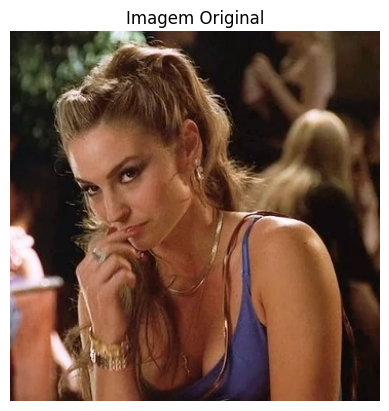

In [15]:
# Upload da imagem
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Ler imagem com OpenCV
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar imagem original
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Imagem Original")
plt.show()

Faces detectadas: 1


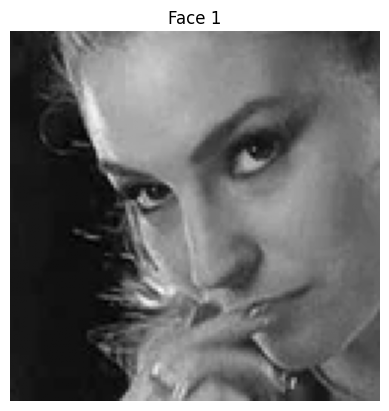

In [16]:
# Criar detector HaarCascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Converter para cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detectar faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

print("Faces detectadas:", len(faces))

# Mostrar cada face detectada
for i, (x, y, w, h) in enumerate(faces):
    face_roi = gray[y:y+h, x:x+w]   # região do rosto
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face_roi, cmap="gray")
    plt.axis("off")
    plt.title(f"Face {i+1}")
plt.show()

In [17]:
# Usar a classe já criada
system = FaceRecognitionSystem()

if len(faces) > 0:
    (x, y, w, h) = faces[0]  # pega a primeira face
    face_roi = gray[y:y+h, x:x+w]

    # Extrair embedding (vetor de 64 valores)
    embedding = system.extract_face_embedding(face_roi)

    print("Embedding da face (64 valores):")
    print(embedding)
    print("Dimensão do vetor:", embedding.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Embedding da face (64 valores):
[0.         0.03676298 0.         0.         0.02215789 0.
 0.00317044 0.         0.         0.05598144 0.1042565  0.
 0.         0.00252511 0.         0.02755697 0.         0.
 0.00766499 0.         0.         0.03973061 0.01526165 0.
 0.         0.         0.05575951 0.         0.         0.04404701
 0.03730753 0.03477539 0.         0.         0.         0.03110362
 0.00048754 0.         0.         0.08669161 0.         0.02985018
 0.03006847 0.02648333 0.         0.04691692 0.05474766 0.
 0.05608845 0.09978882 0.         0.         0.         0.
 0.01962673 0.06628969 0.         0.         0.04568744 0.0335618
 0.03936482 0.         0.00068686 0.        ]
Dimensão do vetor: (64,)
